# 思路

竖版海报的快速排版

## 框架图

![framework](https://raw.githubusercontent.com/zhuojg/hacking-design-ai-2020/master/level02-4/images/framework.png)

## 排版思路

让元素和背景的显著部分尽可能的不重叠，这样得到的海报能更好地传达信息。

## 实现思路

1. 裁切主图片的核心内容作为背景
2. 根据文字，生成每一块文字的矩形贴图
3. 计算背景显著性分布
4. 将文字的贴图置入背景，将举行与显著区域的重叠面积作为衡量效果好坏的指标
5. 使用遗传算法，迭代计算出最佳的放置位置
6. 提取矩形所在位置的局部背景，计算主色调，根据主色调选择文字的颜色

## 不足

显然只考虑不重叠，而忽略其他设计规则得到的结果是惨不忍睹的，不过程序确实让标题、logo等元素避开了背景中的显著内容。  
可以将这个思路作为海报自动排版的一部分。

## 注意

1. 需要安装python库Katna，用于图像智能裁切，这个库下载模型的时候需要翻墙
2. 用到了本地字体，如果需要重新运行需要简单配置一下

In [2]:
# Lib import

import os
import colorgram
from PIL import Image, ImageDraw, ImageFont
from Katna.image import Image as kImage
import cv2
import matplotlib.pyplot as plt
import pyimgsaliency as psal
import random
from deap import base, creator, tools, algorithms
import numpy as np
import array
import colorsys

In [3]:
# some input and pre-defined parameters

title = 'Design AI'
desc = 'Hacking-Design-AI 2020 in Tongji Design AI Lab.'

logo_path = './data/logo.jpeg'
# main_image_path = './data/style.jpg'
main_image_path = './data/main_image_2.jpg'

result_size = [1200, 1800]

img_module = kImage()

In [4]:
# calculate background_saliency
def background_saliency(filename):
    mbd = psal.get_saliency_mbd(filename).astype('uint8')
    binary_sal = psal.binarise_saliency_map(mbd,method='adaptive')
    
    return mbd, binary_sal

In [5]:
def background_crop_saliency(filename):
    cv_image = cv2.imread(filename)
    saliency, saliency_binary = background_saliency(filename)
    
    # get resize ratio, but do not resize cvimage, because this will affect cropping result
    height = cv_image.shape[0]
    width = cv_image.shape[1]
    
    height_ratio = result_size[1] / height
    width_ratio = result_size[0] / width
    scale_ratio = max(height_ratio, width_ratio)
    
    # crop bakcground
    crop_list = img_module.crop_image_from_cvimage(
        input_image=cv_image, 
        crop_width=result_size[0] / scale_ratio, 
        crop_height=result_size[1] / scale_ratio, 
        num_of_crops=1)
    
    # return the first crop rect
    crop_rect = crop_list[0]
    x_pos, y_pos, width, height = crop_rect.x, crop_rect.y, crop_rect.w, crop_rect.h
    return  cv_image[y_pos:y_pos + height, x_pos:x_pos + width], saliency_binary[y_pos:y_pos + height, x_pos:x_pos + width]

In [6]:
class Canva:
    def __init__(self, title, main_image_path, desc, logo_path):
        self.canva = None
        self.bg_saliency = None
        
        self.title = title
        self.desc = desc
        self.logo_path = logo_path
        self.main_image_path = main_image_path
        
        self.logo = None
            
            
        # pre=defined parameters
        self.title_font_size = 128
        self.desc_font_size = 48
        
        title_font_path = 'C:\\Users\\jing\\AppData\\Local\\Microsoft\\Windows\\Fonts\\FZDBSJW.TTF'
        desc_font_path = 'C:\\Users\\jing\\AppData\\Local\\Microsoft\\Windows\\Fonts\\OPPOSans-M.ttf'
        self.title_font = ImageFont.truetype(title_font_path, size=self.title_font_size)
        self.desc_font = ImageFont.truetype(desc_font_path, size=self.desc_font_size)
        
        self.title_color = None
        self.desc_color = None
        
        self.position = None
            
    def generate_slides(self):        
        # TODO: 标题和描述文字过长时，需要换行
        self.title_size = self.title_font.getsize(self.title)
        self.desc_size = self.desc_font.getsize(self.desc)
        
        # logo need to be scaled, its height or width cannot be bigger than 1/6 of image's height or width
        logo_img = Image.open(self.logo_path)
        height_ratio = (result_size[1] / 6) / logo_img.size[1]
        width_ratio = (result_size[0] / 6) / logo_img.size[0]
        
        scale_ratio = min(height_ratio, width_ratio)
        logo_img = logo_img.resize((int(logo_img.size[0] * scale_ratio), int(logo_img.size[1] * scale_ratio)), Image.ANTIALIAS)
        
        self.logo_size = logo_img.size
        
        self.logo = logo_img
        
    def generate_background(self):
        bg_img, bg_saliency = background_crop_saliency(self.main_image_path)
        
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
        
        bg_img = Image.fromarray(bg_img)
        bg_saliency = Image.fromarray(bg_saliency)
        
        bg_img = bg_img.resize((result_size[0], result_size[1]), Image.ANTIALIAS)
        
        self.bg_saliency = bg_saliency.resize((result_size[0], result_size[1]), Image.ANTIALIAS)
        self.canva = bg_img
        
    def generate_layout(self, pop_num=100, iter_num=10):
        # generaete layout using generetic algorithm
        creator.create("FitnessMax", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        # Attribute generator 
        toolbox.register("attr_bool", random.random)

        # Structure initializers
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 6)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        def evalOneMax(individual):
            title_rect = (int(individual[0] * result_size[0]), int(individual[1] * result_size[1]), self.title_size[0], self.title_size[1])
            desc_rect = (int(individual[2] * result_size[0]), int(individual[3] * result_size[1]), self.desc_size[0], self.desc_size[1])
            logo_rect = (int(individual[4] * result_size[0]), int(individual[5] * result_size[1]), self.logo_size[0], self.logo_size[1])
            
            # if this three rect is beyond the canva, the result is bad
            if (title_rect[0] + title_rect[2]) > result_size[0] or (title_rect[1] + title_rect[3]) > result_size[1]:
                return 1.,
            
            if (desc_rect[0] + desc_rect[2]) > result_size[0] or (desc_rect[1] + desc_rect[3]) > result_size[1]:
                return 1.,
            
            if (logo_rect[0] + logo_rect[2]) > result_size[0] or (logo_rect[1] + logo_rect[3]) > result_size[1]:
                return 1.,
            
            # multiply three rect and saliency map
            title_canva = np.zeros((result_size[1], result_size[0]), dtype='float')
            desc_canva = np.zeros((result_size[1], result_size[0]), dtype='float')
            logo_canva = np.zeros((result_size[1], result_size[0]), dtype='float')
            
            title_canva[title_rect[1]:title_rect[1]+title_rect[3], title_rect[0]:title_rect[0]+title_rect[2]] = np.ones((title_rect[3], title_rect[2]), dtype='float')
            desc_canva[desc_rect[1]:desc_rect[1]+desc_rect[3], desc_rect[0]:desc_rect[0]+desc_rect[2]] = np.ones((desc_rect[3], desc_rect[2]), dtype='float')
            logo_canva[logo_rect[1]:logo_rect[1]+logo_rect[3], logo_rect[0]:logo_rect[0]+logo_rect[2]] = np.ones((logo_rect[3], logo_rect[2]), dtype='float')
            
            result = self.bg_saliency * title_canva * desc_canva * logo_canva
            
            # return the average value of each pixel
            return np.mean(result),
        
        toolbox.register("evaluate", evalOneMax)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=3)
        
        def loop():
            pop = toolbox.population(n=pop_num)
            hof = tools.HallOfFame(1)
            stats = tools.Statistics(lambda ind: ind.fitness.values)
            stats.register("avg", np.mean)
            stats.register("std", np.std)
            stats.register("min", np.min)
            stats.register("max", np.max)

            pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=iter_num, 
                                           stats=stats, halloffame=hof, verbose=True)
            
            return hof[0]
        
        print('Generating layout...')
        self.position = loop()
        print('Layout generated.')
    
    def generate_text_color(self):
        # TODO: text color should decide by the region it's on, not the whole image
        colors = colorgram.extract(self.main_image_path, 5)
        
        color = colors[0].rgb
        
        color_hsv = colorsys.rgb_to_hsv(color.r, color.g, color.b)
        
        new_hue = color_hsv[0] + 0.5
        new_nue = new_hue if new_hue < 1. else (new_hue - 1.)
        
        new_color = colorsys.hsv_to_rgb(new_hue, color_hsv[1], color_hsv[2])
        
        self.title_color = self.desc_color = tuple([ int(c) for c in new_color])
        
    
    def render(self):
        draw = ImageDraw.Draw(self.canva)
        
        title_pos = (int(self.position[0] * result_size[0]), int(self.position[1] * result_size[1]))
        desc_pos = (int(self.position[2] * result_size[0]), int(self.position[3] * result_size[1]))
        logo_pos = (int(self.position[4] * result_size[0]), int(self.position[5] * result_size[1]))
        
        draw.text(xy=title_pos, text=self.title, fill=self.title_color, font=self.title_font)
        draw.text(xy=desc_pos, text=self.desc, fill=self.desc_color, font=self.desc_font)
        self.canva.paste(self.logo, (logo_pos[0], logo_pos[1], logo_pos[0] + self.logo.size[0], logo_pos[1] + self.logo.size[1]))
    
    def show(self):
        # show in local
        self.canva.show()
        
        # show in notebook
        plt.figure(figsize=(10, 10))
        plt.rcParams['figure.dpi'] = 150 #分辨率
        plt.axis('off')
        plt.imshow(self.canva)


Generating layout...
gen	nevals	avg 	std      	min	max
0  	200   	0.99	0.0994987	0  	1  
1  	127   	0.97	0.170587 	0  	1  
2  	122   	0.905	0.293215 	0  	1  
3  	132   	0.75 	0.433013 	0  	1  
4  	108   	0.45 	0.497494 	0  	1  
5  	131   	0.085	0.278882 	0  	1  
6  	116   	0.02 	0.14     	0  	1  
7  	127   	0.01 	0.0994987	0  	1  
8  	109   	0    	0        	0  	0  
9  	132   	0.005	0.0705337	0  	1  
10 	129   	0.015	0.121552 	0  	1  
11 	118   	0.015	0.121552 	0  	1  
12 	111   	0.005	0.0705337	0  	1  
13 	120   	0.01 	0.0994987	0  	1  
14 	110   	0.025	0.156125 	0  	1  
15 	107   	0.005	0.0705337	0  	1  
16 	118   	0.01 	0.0994987	0  	1  
17 	117   	0.005	0.0705337	0  	1  
18 	127   	0.015	0.121552 	0  	1  
19 	128   	0.015	0.121552 	0  	1  
20 	125   	0.01 	0.0994987	0  	1  
21 	111   	0.01 	0.0994987	0  	1  
22 	136   	0.03 	0.170587 	0  	1  
23 	129   	0.01 	0.0994987	0  	1  
24 	132   	0.01 	0.0994987	0  	1  
25 	116   	0.01 	0.0994987	0  	1  
26 	114   	0.03 	0.170587 	0  	1  
27

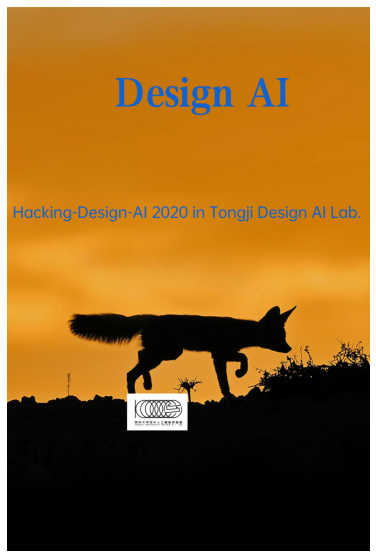

In [7]:
c = Canva(title=title, main_image_path=main_image_path, desc=desc, logo_path=logo_path)
c.generate_slides()
c.generate_background()
c.generate_layout(pop_num=200, iter_num=30)
c.generate_text_color()
c.render()
c.show()